In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
from numpy import argmax
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling as pp
import datetime
import math
from datetime import date
from scipy import stats

# Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# Imbalance Dataset
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

# Model Evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix, f1_score,auc,roc_curve,roc_auc_score, precision_recall_curve

# Modelling Algoritm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import scikitplot as skplt

import warnings
warnings.simplefilter(action='ignore')

In [2]:
SBAdata = pd.read_csv('Xtrain.csv')
df_y = pd.read_csv('Ytrain.csv')
SBAdata = pd.concat([SBAdata, df_y['ChargeOff']], axis=1, sort=False)

In [3]:
date_col = ['ApprovalDate','DisbursementDate']
SBAdata[date_col] = pd.to_datetime(SBAdata[date_col].stack(),format='%d-%b-%y').unstack()

SBAdata['ApprovalFY'].replace('1976A', 1976, inplace=True)
SBAdata['ApprovalFY']= SBAdata['ApprovalFY'].astype(int)

curr_col = ['DisbursementGross', 'BalanceGross', 'GrAppv', 'SBA_Appv']
SBAdata[curr_col] = SBAdata[curr_col].replace('[\$,]', '', regex=True).astype(float) 

SBAdata['LowDoc'] = SBAdata['LowDoc'].replace({'[C, S, A, R, 1, 0]':np.nan})
SBAdata['LowDoc'] = SBAdata['LowDoc'].replace({'N': 0, 'Y':1})
SBAdata['LowDoc'] = np.where((SBAdata['LowDoc'] != 0) & (SBAdata['LowDoc'] != 1), 
                             np.nan, SBAdata.LowDoc)

SBAdata['RevLineCr'] = SBAdata['RevLineCr'].replace({'N': 0, 'Y':1, 'T':0})
SBAdata['RevLineCr'] = SBAdata['RevLineCr'].replace({'0': 0, '1':1, })
SBAdata['RevLineCr'] = np.where((SBAdata['RevLineCr'] != 0) & (SBAdata['RevLineCr'] != 1), 
                                np.nan, SBAdata.RevLineCr)

SBAdata['NewExist'] = SBAdata['NewExist'].replace({1.0: 0, 2.0:1, 0:np.nan}).fillna(0).astype(int)

In [4]:
SBAdata['FranchiseCode'] = SBAdata['FranchiseCode'].replace(1,0 )
SBAdata['FranchiseCode'] = np.where((SBAdata.FranchiseCode != 0 ), 1, SBAdata.FranchiseCode)

SBAdata.rename(columns={"FranchiseCode": "Is_Franchised"}, inplace=True)

SBAdata['CreateJob'] = np.where((SBAdata.CreateJob > 0 ),1,SBAdata.CreateJob)
SBAdata.rename(columns={"CreateJob": "Is_CreatedJob"}, inplace=True)

SBAdata['RetainedJob'] = np.where((SBAdata.RetainedJob > 0 ),1,SBAdata.RetainedJob)
SBAdata.rename(columns={"RetainedJob": "Is_RetainedJob"}, inplace=True)

SBAdata['RealEstate'] = SBAdata['Term'].apply(lambda x: 1 if x >= 240 else 0)

SBAdata['DaysTerm'] =  SBAdata['Term']*30
SBAdata['Active'] = SBAdata['DisbursementDate'] + pd.TimedeltaIndex(SBAdata['DaysTerm'], unit='D')

startdate = datetime.datetime.strptime('2007-12-1', "%Y-%m-%d").date()
enddate = datetime.datetime.strptime('2009-06-30', "%Y-%m-%d").date()

SBAdata['Recession'] = SBAdata['Active'].apply(lambda x: 1 if startdate <= x <= enddate else 0)

In [5]:
ind_code = SBAdata['NAICS']

def get_code(ind_code):
    if ind_code <= 0:
        return 0
    
    return (ind_code // 10 ** (int(math.log(ind_code, 10)) - 1))


def sector_name(i):
    
    def_code = {11:'Agriculture, Forestry, Fishing & Hunting', 21:'Mining, Quarying, Oil & Gas',
                22:'Utilities', 23:'Constuction', 31:'Manufacturing', 32:'Manufacturing', 33:'Manufacturing',
                42:'Wholesale Trade', 44:'Retail Trade', 45:'Retail Trade', 48:'Transportation & Warehousing',
                49:'Transportation & Warehousing', 51:'Information', 52:'Finance & Insurance', 
                53:'Real Estate, Rental & Leasing', 54:'Professional, Scientific & Technical Service',
                55:'Management of Companies & Enterprise', 
                56:'Administrative, Support, Waste Management & Remediation Service',
                61:'Educational Service', 62:'Health Care & Social Assistance',
                71:'Arts, Entertainment & Recreation', 72:'Accomodation & Food Service',
                81:'Other Servieces (Ex: Public Administration)', 92:'Public Administration'
               }
    
    if i in def_code:
        return def_code[i]
    
def def_rate(i):
    
    sector_default = {21:0.08, 11:0.09, 55:0.10, 
                      62: 0.10, 22:0.14, 
                      92:0.15,54:0.19, 
                      42:0.19,31:0.19,
                      32:0.16,33:0.14,
                      81:0.20,71:0.21,
                      72:0.22,44:0.22,
                      45:0.23,23:0.23,
                      56:0.24,61:0.24,
                      51:0.25,48:0.27,
                      49:0.23,52:0.28,53:0.29}
    
    if i in sector_default:
        return sector_default[i]

    return np.nan

In [6]:
SBAdata['ind_code'] = SBAdata.NAICS.apply(get_code)

SBAdata['Sector_name'] = SBAdata.ind_code.apply(sector_name)

SBAdata['Sector_rate'] = SBAdata.NAICS.apply(get_code).apply(def_rate)

In [7]:
def_state = SBAdata.groupby(['State', 'ChargeOff'])['State'].count().unstack('ChargeOff')
def_state['Def_Percent'] = def_state[1]/(def_state[1] + def_state[0])
def_state = def_state.drop(axis=1, columns=[0.0, 1.0]).round(1).to_dict()

def state_def_rate(i):
    def_state = {'AK': 0.1,'AL': 0.2, 'AR': 0.2, 'AZ': 0.2,'CA': 0.2, 'CO': 0.2, 'CT': 0.1, 'DC': 0.2,
                 'DE': 0.2, 'FL': 0.3, 'GA': 0.2, 'HI': 0.2, 'IA': 0.1, 'ID': 0.1, 'IL': 0.2, 'IN': 0.2, 
                 'KS': 0.1, 'KY': 0.2, 'LA': 0.2, 'MA': 0.1, 'MD': 0.2, 'ME': 0.1, 'MI': 0.2, 'MN': 0.1,
                 'MO': 0.2, 'MS': 0.2, 'MT': 0.1, 'NC': 0.2, 'ND': 0.1, 'NE': 0.1, 'NH': 0.1, 'NJ': 0.2,
                 'NM': 0.1, 'NV': 0.2, 'NY': 0.2, 'OH': 0.2, 'OK': 0.2, 'OR': 0.2, 'PA': 0.1, 'RI': 0.1,
                 'SC': 0.2, 'SD': 0.1, 'TN': 0.2, 'TX': 0.2, 'UT': 0.2, 'VA': 0.2, 'VT': 0.1, 'WA': 0.1,
                 'WI': 0.1, 'WV': 0.2, 'WY': 0.1}

    if i in def_state:
        return def_state[i]

In [8]:
SBAdata['State_rate'] = SBAdata.State.apply(state_def_rate)

In [9]:
SBAdata['Portion_SBA_Bank'] = SBAdata['SBA_Appv']/SBAdata['GrAppv']
SBAdata = SBAdata[SBAdata['DisbursementDate'] <= pd.Timestamp(2010, 12, 31)]

In [10]:
SBAdata['LowDoc'] = np.where((SBAdata['LowDoc'] == np.nan) & (SBAdata['DisbursementGross'] < 150000),
                             1, 
                             SBAdata.LowDoc)

SBAdata['LowDoc'] = np.where((SBAdata['LowDoc'] == np.nan) & (SBAdata['DisbursementGross'] >= 150000),
                             0,
                             SBAdata.LowDoc)

SBAdata = SBAdata[(SBAdata['LowDoc'] == 0) | (SBAdata['LowDoc'] == 1)]

In [11]:
SBAdata = SBAdata.drop(axis=1, columns=['Name','Bank','NAICS', 'BankState', 'Active', 'DaysTerm'])

In [12]:
SBAdata.dropna(subset=['City', 'State','LowDoc', 'Sector_rate', 'Sector_name', 'RevLineCr'], inplace=True)

In [13]:
SBAdata = SBAdata.drop(axis =1, columns = ['City','State', 'Zip', 'UrbanRural', 'LowDoc', 
                                           'ApprovalDate', 'ApprovalFY', 'SBA_Appv','DisbursementDate', 
                                           'Sector_name','BalanceGross'])

In [14]:
SBAdata['DisbursementGross'] = np.log(SBAdata['DisbursementGross'])

outliers1_drop = SBAdata[(SBAdata['DisbursementGross'] > 14.9)].index
SBAdata.drop(outliers1_drop, inplace=True)

SBAdata['GrAppv'] = np.log(SBAdata['GrAppv'])

outliers2_drop = SBAdata[(SBAdata['GrAppv'] < 7.5)].index
SBAdata.drop(outliers2_drop, inplace=True)

wrong_input = SBAdata[(SBAdata['NoEmp'] == 0)].index
SBAdata.drop(wrong_input, inplace=True)

SBAdata['NoEmp']= stats.boxcox(SBAdata['NoEmp'])[0]

outliers3_drop = SBAdata[(SBAdata['NoEmp'] > 3.3)].index
SBAdata.drop(outliers3_drop, inplace=True)

wrong_input_2 = SBAdata[(SBAdata['Term'] < 75)].index
wrong_input_3 = SBAdata[(SBAdata['Term'] > 276)].index
SBAdata.drop(wrong_input_2, inplace=True)
SBAdata.drop(wrong_input_3, inplace=True)

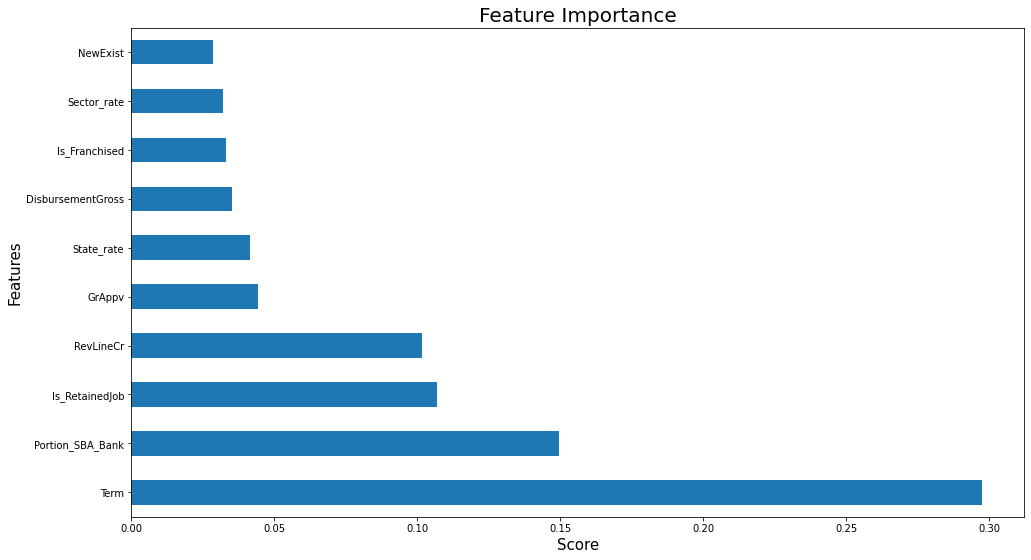

In [15]:
y = SBAdata['ChargeOff']
X = SBAdata.drop(columns=['ChargeOff'], axis=1)


model = XGBClassifier()
model.fit(X,y)

feat_importances = pd.Series(model.feature_importances_, index = X.columns)

f, ax = plt.subplots(figsize = (16,9))

feat_importances.nlargest(10).plot(kind = 'barh')

plt.title('Feature Importance', fontsize = 20)
plt.ylabel('Features', fontsize = 15)
plt.xlabel('Score', fontsize = 15)

plt.show()

In [16]:
SBAdata = SBAdata[['RevLineCr', 'Term', 'Portion_SBA_Bank', 'GrAppv', 'State_rate', 'DisbursementGross',
            'Is_RetainedJob', 'Sector_rate', 'Recession', 'Is_CreatedJob', 'ChargeOff']]
SBAdata.shape

(15764, 11)

In [17]:
y = SBAdata['ChargeOff']
X = SBAdata.drop(columns=['ChargeOff'], axis = 1)
scale = StandardScaler()
X_scaled = scale.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, 
    y, 
    test_size = 0.25, 
    random_state = 27, 
    stratify = y)

over = SMOTE(sampling_strategy='minority')
under = RandomUnderSampler()
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

X_train, y_train = pipeline.fit_resample(X_train, y_train)

In [21]:
def model_evaluation(algo,X_train,y_train,X_test,y_test):
    algo.fit(X_train,y_train)
    y_train_ypred = algo.predict(X_train)
    y_train_prob = algo.predict_proba(X_train)[:,-1]

    y_test_ypred = algo.predict(X_test)
    y_test_prob = algo.predict_proba(X_test)[:,-1]
    y_probas = algo.predict_proba(X_test)
    
    # Confussion Matrix
    
    plot_confusion_matrix(algo, X_test, y_test)
    plt.show() 
    print('='*100)
    print('Classification Report: \n', classification_report(y_test, y_test_ypred, digits=3))
    print('='*100)
    
    # ROC Curve
    
    skplt.metrics.plot_roc(y_test, y_probas,figsize=(16,9))

def optimal_model(clf, params,X_train,y_train,X_test,y_test ):
    
    search = GridSearchCV(estimator=clf,
                          param_grid=params,
                          scoring = 'f1',
                          n_jobs = -1,
                          cv = 3,
                          verbose=True)

    
    search.fit(X_train, y_train)
    
    best = search.best_estimator_
    best_model = best.fit(X_train, y_train)

    y_test_ypred = best_model.predict(X_test)
    y_test_prob = best_model.predict_proba(X_test)[:,-1]
    y_probas = best_model.predict_proba(X_test)
    
    print('Best parameters: \n',search.best_params_)
    print('='*70)
    
    
    #Confussion Matrix
    
    plot_confusion_matrix(clf, X_test, y_test)
    plt.show() 
    print('='*100)
    print('Classification Report: \n', classification_report(y_test, y_test_ypred, digits=3))
    print('='*100)
    
    
    # ROC Curve

    skplt.metrics.plot_roc(y_test, y_probas,figsize=(16,9) )

In [22]:
params ={"learning_rate"    : [0.05, 0.10, 0.15] ,
         "max_depth"        : [ 3, 4, 5, 6],
         "min_child_weight" : [ 1, 3, 5, 7 ],
         "gamma"            : [ 0.0, 0.1, 0.2 ],
         "colsample_bytree" : [ 0.3, 0.4, 0.5] }


{'colsample_bytree': 0.5, 'gamma': 0.0, 'learning_rate': 0.15, 'max_depth': 6, 'min_child_weight': 1}


xgb = XGBClassifier(base_score = 0.5, booster = 'gbtree', 
                    colsample_bylevel = 1, colsample_bynode = 1, 
                    colsample_bytree = 0.5, gamma = 0.0,
                    learning_rate = 0.15, max_delta_step = 0, 
                    max_depth = 6, min_child_weight = 1, 
                    missing = None, n_estimators = 150, 
                    n_jobs = 1, nthread = None, objective ='binary:logistic',
                    reg_alpha = 0, reg_lambda = 1, scale_pos_weight = 1, 
                    subsample = 1, verbosity = 1)

optimal_model(xgb, params, X_train, y_train, X_test, y_test)



Fitting 3 folds for each of 432 candidates, totalling 1296 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed:  4.7min finished


Best parameters: 
 {'colsample_bytree': 0.5, 'gamma': 0.0, 'learning_rate': 0.15, 'max_depth': 6, 'min_child_weight': 1}


NotFittedError: need to call fit or load_model beforehand